In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import torch
import matplotlib.pyplot as plt
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# check GPU status
!nvidia-smi

Sun Feb  2 16:08:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:84:00.0 Off |                    0 |
|  0%   39C    P0             57W /  300W |       0MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# setup device
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# 1. load config
import json
config_fname = 'configs/ours-pretrain-diffusion-aligned-frames.json'
# config_fname = 'configs/ours-pretrain-diffusion-patchify-video.json'

config = json.load(open(config_fname))

In [8]:
check_dict(config)

data                                                         dict_keys(['DENSE_filenames', 'train_subject_exclude_patterns', 'val_subject_patterns', 'test_subject_patterns'])
datasets                                                     dict_keys(['train', 'val', 'test'])
networks                                                     dict_keys(['registration', 'latent'])
training                                                     dict_keys(['seed', 'scheme', 'batch_forward_method', 'reg_forward_data', 'regression_output_type', 'mask_padded_frames', 'resize_before_regression', 'batch_size', 'epochs', 'enable_random_rotate', 'random_rotate_prob_thres', 'epochs_without_improvement_tolerance', 'save_best_model_interval', 'training_latent_model_epoch_interval', 'training_motion_decoder_epoch_interval', 'optimization'])
losses                                                       dict_keys(['denoising'])
evaluation                                                   dict_keys(['noise_prediction_

In [9]:
from modules.data import glob_star
import json
import glob

def load_DENSE_data(DENSE_data_fnames):
    # Load raw data
    all_data_raw = []
    all_data_fnames = list(glob_star(DENSE_data_fnames))
    for all_data_fname in all_data_fnames:
        all_data_raw += np.load(all_data_fname, allow_pickle=True).tolist()
    
    # Keep only the necessary files
    all_data = []
    for datum_idx, datum_raw in enumerate(all_data_raw):
        loaded_datum = {}

        # loaded_datum = get_data_from_slice(datum_raw, data_to_feed)        
        loaded_datum['DENSE_disp'] = np.stack([datum_raw['DENSE_Lag_displacement_field_X'], datum_raw['DENSE_Lag_displacement_field_Y']], axis=0)
        loaded_datum['myo_masks'] = datum_raw['DENSE_myo_masks_rescaled']#[None]
        # loaded_datum['PositionA'] = datum_raw['AnalysisInfo']['PositionA']
        # loaded_datum['PositionB'] = datum_raw['AnalysisInfo']['PositionB']
        loaded_datum['slice_mat_filename'] = str(datum_raw.get('DENSE_slice_mat_filename', 'None'))
        loaded_datum['slice_location'] = float(datum_raw.get('DENSE_slice_location', -1e-3))
        
        loaded_datum['subject_id'] = datum_raw['patient_id']
        loaded_datum['slice_idx'] = datum_idx
        loaded_datum['slice_full_id'] = f'{datum_raw["patient_id"]}-{datum_idx}'
        loaded_datum['SequenceInfo'] = datum_raw['SequenceInfo']
        loaded_datum['ori_n_frames'] = loaded_datum['myo_masks'].shape[-1]

        all_data.append(loaded_datum)
    return all_data

all_data = load_DENSE_data(config['data']['DENSE_filenames'])

In [10]:
# 2. load all data splits
train_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') not in config['data']['train_subject_exclude_patterns']]
}
val_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['val_subject_patterns']]
}
test_split = {
    'info': {},
    'data': [d for d in all_data if d['subject_id'].replace('-DENSE', '').replace('-Cine', '') in config['data']['test_subject_patterns']]
}

data_splits = {
    'train': train_split,
    'val': val_split,
    'test': test_split
}

In [11]:
check_dict(train_split['data'][0])

DENSE_disp                                                   (2, 48, 48, 22)     
myo_masks                                                    (128, 128, 22)      
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
SequenceInfo                                                 (2, 3)              
ori_n_frames                                                 22                  


In [12]:
# 4. Building dataset
from modules.data.dataset import build_datasets
datasets = build_datasets(data_splits, config['datasets'])
# print the length of each dataset
for dataset_name, dataset in datasets.items():
    print(f'{dataset_name} dataset length: {len(dataset)}')

Using Lagrangian displacement field
Using Lagrangian displacement field
Using Lagrangian displacement field
train dataset length: 1634
val dataset length: 295
test dataset length: 297


In [13]:
check_dict(datasets['train'][0])

DENSE_disp                                                   (2, 16, 48, 48)     
src                                                          (1, 16, 128, 128)   
tar                                                          (1, 16, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
slice_location                                               61.970369270087     
subject_id                                                   00_Circle_V10       
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
ori_n_frames                                                 22                  
src_starting_frame_idx                                       0                   
src_total_n_frames                                           22                  
tar_starting_frame_idx

In [14]:
check_dict(datasets['train'][-1])

DENSE_disp                                                   (2, 16, 48, 48)     
src                                                          (1, 16, 128, 128)   
tar                                                          (1, 16, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/dod_ya_ROI.3.mat
slice_location                                               -0.4107601991522    
subject_id                                                   dod_ya              
slice_idx                                                    740                 
slice_full_id                                                dod_ya-740          
ori_n_frames                                                 55                  
src_starting_frame_idx                                       0                   
src_total_n_frames                                           55                  
tar_starting_frame_idx              

In [15]:
# 6. Building model
from models import build_model
networks = {}
for model_name, model_config in config['networks'].items():
    networks[model_name] = build_model(model_config)
    networks[model_name] = networks[model_name].to( device)
# model = build_model(config['network'])

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30


In [16]:
# Training
from modules.trainer import build_trainer
config['training']['epochs'] = 15 # set only 30 epochs for debugging
config['training']['batch_size'] = 128
config['training']['learning_rate'] = 1e-4
trainer = build_trainer(config['training'], device, config)

In [17]:
exp_dict, trained_models, wandb_experiment = trainer.train(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    use_tensorboard=False,
    tensorboard_log_dir='tensorboard',
    use_wandb=False)

Loss denoising_error is disabled
latent lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7f700a1404c0>


  0%|          | 0/15 [00:00<?, ?it/s]

13it [01:21,  6.24s/it]
3it [00:13,  4.48s/it].999e-02:   0%|          | 0/15 [01:21<?, ?it/s]
Epoch 0 | Train Loss 1.999e-02:   7%|▋         | 1/15 [01:34<22:09, 94.96s/it]

{
    "train/denoising": 0.053204319798029386,
    "train/total_loss": 0.10640863959605877,
    "train/noise_prediction_error": 0.053204319798029386,
    "val/denoising": 0.019873802239696186,
    "val/total_loss": 0.03974760447939237,
    "val/noise_prediction_error": 0.019873802239696186
}


13it [01:11,  5.53s/it]
3it [00:13,  4.45s/it].717e-02:   7%|▋         | 1/15 [02:47<22:09, 94.96s/it]
Epoch 1 | Train Loss 1.717e-02:  13%|█▎        | 2/15 [03:00<19:23, 89.49s/it]

{
    "train/denoising": 0.018810622250804536,
    "train/total_loss": 0.03762124450160907,
    "train/noise_prediction_error": 0.018810622250804536,
    "val/denoising": 0.015492045631011328,
    "val/total_loss": 0.030984091262022655,
    "val/noise_prediction_error": 0.015492045631011328
}


13it [00:55,  4.28s/it]
3it [00:13,  4.43s/it].297e-02:  13%|█▎        | 2/15 [03:56<19:23, 89.49s/it]
Epoch 2 | Train Loss 1.297e-02:  20%|██        | 3/15 [04:09<16:03, 80.26s/it]

{
    "train/denoising": 0.014493120547670584,
    "train/total_loss": 0.02898624109534117,
    "train/noise_prediction_error": 0.014493120547670584,
    "val/denoising": 0.014455122873187065,
    "val/total_loss": 0.02891024574637413,
    "val/noise_prediction_error": 0.014455122873187065
}


13it [00:44,  3.42s/it]
3it [00:13,  4.44s/it].121e-02:  20%|██        | 3/15 [04:54<16:03, 80.26s/it]
Epoch 3 | Train Loss 1.121e-02:  27%|██▋       | 4/15 [05:08<13:06, 71.51s/it]

{
    "train/denoising": 0.012542397285310121,
    "train/total_loss": 0.025084794570620243,
    "train/noise_prediction_error": 0.012542397285310121,
    "val/denoising": 0.011996012491484484,
    "val/total_loss": 0.023992024982968967,
    "val/noise_prediction_error": 0.011996012491484484
}


13it [01:08,  5.25s/it]
3it [00:04,  1.37s/it].010e-02:  27%|██▋       | 4/15 [06:16<13:06, 71.51s/it]
Epoch 4 | Train Loss 1.010e-02:  33%|███▎      | 5/15 [06:20<11:59, 71.97s/it]

{
    "train/denoising": 0.011173157236323906,
    "train/total_loss": 0.022346314472647812,
    "train/noise_prediction_error": 0.011173157236323906,
    "val/denoising": 0.010630068990091482,
    "val/total_loss": 0.021260137980182964,
    "val/noise_prediction_error": 0.010630068990091482
}


13it [01:14,  5.76s/it]
3it [00:13,  4.43s/it].678e-03:  33%|███▎      | 5/15 [07:36<11:59, 71.97s/it]
Epoch 5 | Train Loss 9.678e-03:  40%|████      | 6/15 [07:49<11:38, 77.62s/it]

{
    "train/denoising": 0.010541866820019025,
    "train/total_loss": 0.02108373364003805,
    "train/noise_prediction_error": 0.010541866820019025,
    "val/denoising": 0.009495571566124758,
    "val/total_loss": 0.018991143132249515,
    "val/noise_prediction_error": 0.009495571566124758
}


13it [01:18,  6.00s/it]
3it [00:13,  4.38s/it].011e-02:  40%|████      | 6/15 [09:07<11:38, 77.62s/it]
Epoch 6 | Train Loss 1.011e-02:  47%|████▋     | 7/15 [09:20<10:57, 82.18s/it]

{
    "train/denoising": 0.00941785116894887,
    "train/total_loss": 0.01883570233789774,
    "train/noise_prediction_error": 0.00941785116894887,
    "val/denoising": 0.008682887380321821,
    "val/total_loss": 0.017365774760643642,
    "val/noise_prediction_error": 0.008682887380321821
}


13it [01:17,  5.93s/it]
3it [00:07,  2.62s/it].739e-03:  47%|████▋     | 7/15 [10:38<10:57, 82.18s/it]
Epoch 7 | Train Loss 8.739e-03:  53%|█████▎    | 8/15 [10:46<09:42, 83.19s/it]

{
    "train/denoising": 0.008596817318063516,
    "train/total_loss": 0.017193634636127032,
    "train/noise_prediction_error": 0.008596817318063516,
    "val/denoising": 0.008247954460481802,
    "val/total_loss": 0.016495908920963604,
    "val/noise_prediction_error": 0.008247954460481802
}


13it [01:11,  5.47s/it]
3it [00:13,  4.34s/it].660e-03:  53%|█████▎    | 8/15 [11:57<09:42, 83.19s/it]
Epoch 8 | Train Loss 7.660e-03:  60%|██████    | 9/15 [12:10<08:21, 83.63s/it]

{
    "train/denoising": 0.008232715969475416,
    "train/total_loss": 0.016465431938950833,
    "train/noise_prediction_error": 0.008232715969475416,
    "val/denoising": 0.00803579514225324,
    "val/total_loss": 0.01607159028450648,
    "val/noise_prediction_error": 0.00803579514225324
}


13it [01:17,  5.97s/it]
3it [00:13,  4.34s/it].520e-03:  60%|██████    | 9/15 [13:28<08:21, 83.63s/it]
Epoch 9 | Train Loss 7.520e-03:  67%|██████▋   | 10/15 [13:41<07:09, 85.92s/it]

{
    "train/denoising": 0.007634073531684967,
    "train/total_loss": 0.015268147063369934,
    "train/noise_prediction_error": 0.007634073531684967,
    "val/denoising": 0.007508187709997098,
    "val/total_loss": 0.015016375419994196,
    "val/noise_prediction_error": 0.007508187709997098
}


13it [01:17,  5.94s/it]
3it [00:13,  4.35s/it]7.248e-03:  67%|██████▋   | 10/15 [14:59<07:09, 85.92s/it]
Epoch 10 | Train Loss 7.248e-03:  73%|███████▎  | 11/15 [15:12<05:49, 87.36s/it]

{
    "train/denoising": 0.007358482322440698,
    "train/total_loss": 0.014716964644881396,
    "train/noise_prediction_error": 0.007358482322440698,
    "val/denoising": 0.0067984348473449545,
    "val/total_loss": 0.013596869694689909,
    "val/noise_prediction_error": 0.0067984348473449545
}


13it [01:17,  5.97s/it]
3it [00:13,  4.38s/it]6.316e-03:  73%|███████▎  | 11/15 [16:30<05:49, 87.36s/it]
Epoch 11 | Train Loss 6.316e-03:  80%|████████  | 12/15 [16:43<04:25, 88.50s/it]

{
    "train/denoising": 0.007045353189683878,
    "train/total_loss": 0.014090706379367756,
    "train/noise_prediction_error": 0.007045353189683878,
    "val/denoising": 0.007206844165921211,
    "val/total_loss": 0.014413688331842422,
    "val/noise_prediction_error": 0.007206844165921211
}
Epochs without improvement: 1 / 30


13it [01:05,  5.07s/it]
3it [00:13,  4.34s/it]6.615e-03:  80%|████████  | 12/15 [17:49<04:25, 88.50s/it]
Epoch 12 | Train Loss 6.615e-03:  87%|████████▋ | 13/15 [18:02<02:51, 85.73s/it]

{
    "train/denoising": 0.006916873909246463,
    "train/total_loss": 0.013833747818492927,
    "train/noise_prediction_error": 0.006916873909246463,
    "val/denoising": 0.006770963470141093,
    "val/total_loss": 0.013541926940282186,
    "val/noise_prediction_error": 0.006770963470141093
}


13it [01:17,  5.94s/it]
3it [00:13,  4.34s/it]6.483e-03:  87%|████████▋ | 13/15 [19:20<02:51, 85.73s/it]
Epoch 13 | Train Loss 6.483e-03:  93%|█████████▎| 14/15 [19:33<01:27, 87.19s/it]

{
    "train/denoising": 0.0069083420989605095,
    "train/total_loss": 0.013816684197921019,
    "train/noise_prediction_error": 0.0069083420989605095,
    "val/denoising": 0.00624976446852088,
    "val/total_loss": 0.01249952893704176,
    "val/noise_prediction_error": 0.00624976446852088
}


13it [01:16,  5.92s/it]
3it [00:13,  4.36s/it]6.292e-03:  93%|█████████▎| 14/15 [20:50<01:27, 87.19s/it]
Epoch 14 | Train Loss 6.292e-03: 100%|██████████| 15/15 [21:04<00:00, 84.27s/it]

{
    "train/denoising": 0.006557226395950868,
    "train/total_loss": 0.013114452791901736,
    "train/noise_prediction_error": 0.006557226395950868,
    "val/denoising": 0.006518124602735043,
    "val/total_loss": 0.013036249205470085,
    "val/noise_prediction_error": 0.006518124602735043
}
Epochs without improvement: 1 / 30


In [18]:
# generate training set prediction
train_pred, train_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='train',
    mode='test')

test_loss_dict:  {'train/denoising': 0.006975536628697927, 'train/total_loss': 0.013951073257395854, 'train/noise_prediction_error': 0.006975536628697927}


In [19]:
# test model
test_pred, test_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='test',
    mode='test')

test_loss_dict:  {'test/denoising': 0.007207265744606654, 'test/total_loss': 0.014414531489213308, 'test/noise_prediction_error': 0.007207265744606654}


In [21]:
check_dict(test_pred[0])

latent_pred                                                  (16, 16, 16, 16)    
reg_disp_pred                                                None                
noise_pred                                                   (16, 16, 16, 16)    
DENSE_disp                                                   (2, 16, 48, 48)     
src                                                          (1, 16, 128, 128)   
tar                                                          (1, 16, 128, 128)   
slice_mat_filename                                           /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/033_S01_base_auto.1_ROI.1.mat
slice_location                                               76.947609505431     
subject_id                                                   033                 
slice_idx                                                    31                  
slice_full_id                                                033-31              
ori_n_frames           

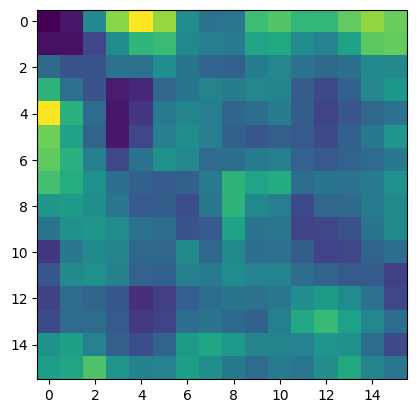

In [24]:
plt.imshow(test_pred[0]['noise_pred'][0,0])

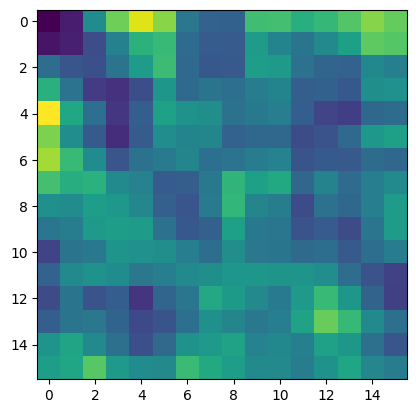

In [25]:
plt.imshow(test_pred[0]['noise'][0,0])

In [20]:
# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
for check_pair_idx in [0,5,10,20]:
    src = train_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = train_pred[check_pair_idx]['tar'][0].astype(float)[0]
    src_tar_diff = src - tar
    deformed = train_pred[check_pair_idx]['deformed_source_pred'][0][0]
    deformed_tar_diff = np.abs(deformed - tar)
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = train_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()

    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_train_{check_pair_idx}.png', bbox_inches='tight')

# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
# for check_pair_idx in [0,5,10,20]:
# for check_pair_idx in [22, 32, 45, 60]:
for check_pair_idx in [22, 32, 45]:
    src = test_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = test_pred[check_pair_idx]['tar'][0].astype(float)[0]
    # src_tar_diff = np.abs(src - tar)
    src_tar_diff = src - tar
    deformed = test_pred[check_pair_idx]['deformed_source_pred'][0][0]
    # deformed_tar_diff = np.abs(deformed - tar)
    deformed_tar_diff = deformed - tar
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = test_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')
    
    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_test_{check_pair_idx}.png', bbox_inches='tight')


KeyError: 'deformed_source_pred'

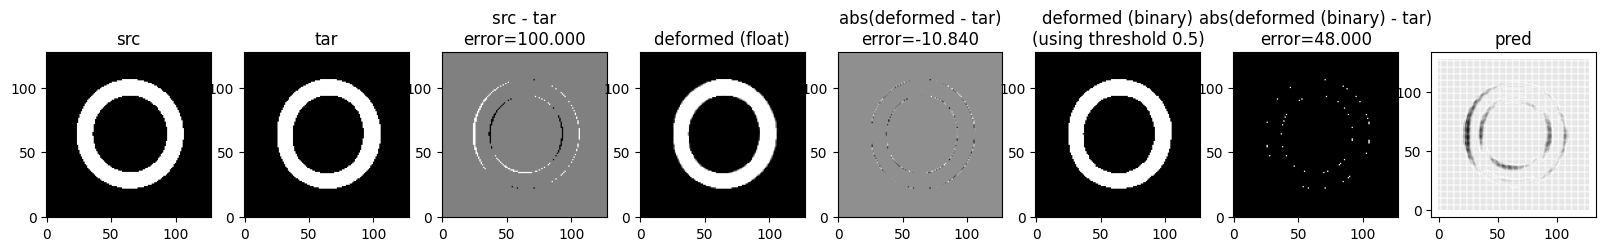

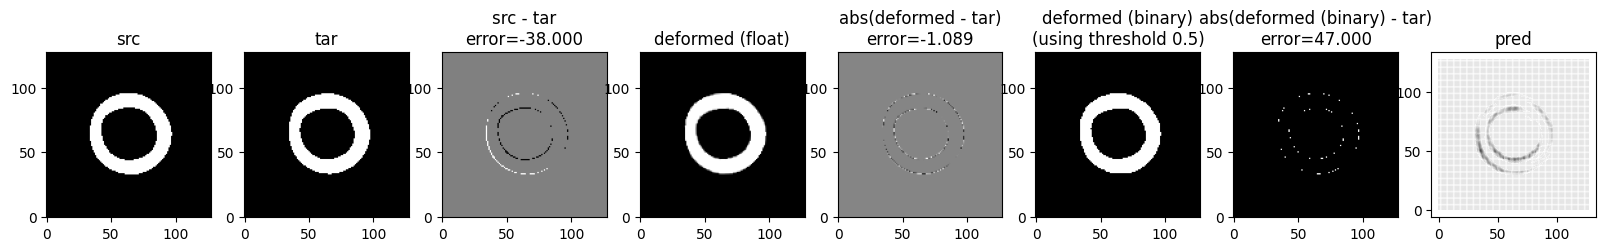

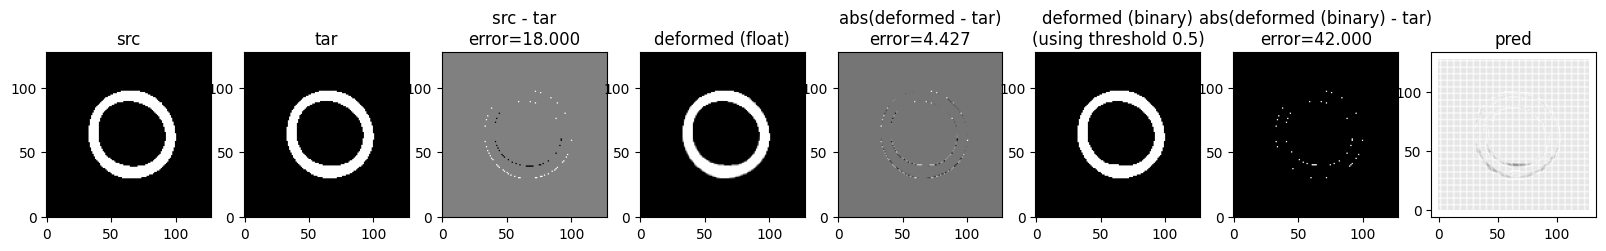

In [ ]:
# check the source, target, abs(source- target), deformed, abs(deformed - target), pred disp, DENSE disp
import numpy as np
import matplotlib.pyplot as plt
# for check_pair_idx in [0,5,10,20]:
# for check_pair_idx in [22, 32, 45, 60]:
for check_pair_idx in [22, 32, 45]:
    src = test_pred[check_pair_idx]['src'][0].astype(float)[0]
    tar = test_pred[check_pair_idx]['tar'][0].astype(float)[0]
    # src_tar_diff = np.abs(src - tar)
    src_tar_diff = src - tar
    deformed = test_pred[check_pair_idx]['deformed_source_pred'][0][0]
    # deformed_tar_diff = np.abs(deformed - tar)
    deformed_tar_diff = deformed - tar
    deformed_bin = deformed > 0.5
    deformed_bin_tar_diff = np.abs(deformed_bin - tar)
    disp_pred = test_pred[check_pair_idx]['displacement_pred'][:, 0]
    # disp_DENSE = test_pred[check_pair_idx]['DENSE_disp']

    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    axs[0].imshow(src, cmap='gray')
    axs[0].set_title('src')
    axs[1].imshow(tar, cmap='gray')
    axs[1].set_title('tar')
    axs[2].imshow(src_tar_diff, cmap='gray')
    axs[2].set_title(f'src - tar\nerror={src_tar_diff.sum():.3f}')

    axs[3].imshow(deformed, cmap='gray')
    axs[3].set_title('deformed (float)')
    axs[4].imshow(deformed_tar_diff, cmap='gray')
    axs[4].set_title(f'abs(deformed - tar)\nerror={deformed_tar_diff.sum():.3f}')

    axs[5].imshow(deformed_bin, cmap='gray')
    axs[5].set_title('deformed (binary)\n(using threshold 0.5)')
    axs[6].imshow(deformed_bin_tar_diff, cmap='gray')
    axs[6].set_title(f'abs(deformed (binary) - tar)\nerror={deformed_bin_tar_diff.sum():.3f}')

    axs[7].quiver(disp_pred[0], disp_pred[1], scale=1, units='xy')
    # axs[7].invert_yaxis()
    axs[7].set_title('pred')
    axs[7].set_aspect('equal')

    for axs_idx in range(7):
        # invert the y axis of the imshow results to match the quiver result
        axs[axs_idx].invert_yaxis()
    # axs[6].quiver(disp_DENSE[0], disp_DENSE[1], scale=10)
    # axs[6].set_title('DENSE')
    # axs[6].set_aspect('equal')
    
    # save figure
    # fig.savefig(save_exp_dir / f'check_pair_test_{check_pair_idx}.png', bbox_inches='tight')
